In [155]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [156]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Nominal trajectory, measurements

In [157]:
class MonoCamera:
    def __init__(self):
        self.std = 0.1
        self.v = scipy.stats.norm(0, self.std)
        
    def control(self, X, t):
        #g_des = (np.sin(0.05*t)+1)**4*np.sin(0.5*t)
        #g_des = np.sin(2*t)
        #g, d = X 
        #gain = 0.5
        # u_g = 4*np.sin(2*t) #gain*(g_des-g)
        u_g = np.piecewise(t,
                   [t < 2, (t >= 2) & (t < 8), t >= 8],
                   [0,
                    lambda t: 8*np.sin(10*t),
                    0])
        return u_g
    
    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g # - 0.01*g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot
    
    # g = ground speed
    # d = distance
    def h(self, X, t):
        g, d = X
        u_g = self.control(X, t)
        # define all the sensors I want in the system to use for simulation
        # g = ground speed
        # d = distance
        y = np.array([g/d + self.v.rvs(g.shape), 
                      d**g + self.v.rvs(g.shape),
                      d*g + self.v.rvs(g.shape),
                      d/g + self.v.rvs(g.shape),
                      (g) + self.v.rvs(g.shape)])
        return y
    
    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [ ]:
sys = MonoCamera()

x0 = np.array([5, 3]) # initial conditions
tsim = np.arange(0, 10, 0.01) # simulation  time

X, U, Y = sys.simulate(x0, tsim)



(0.0, 10.0)

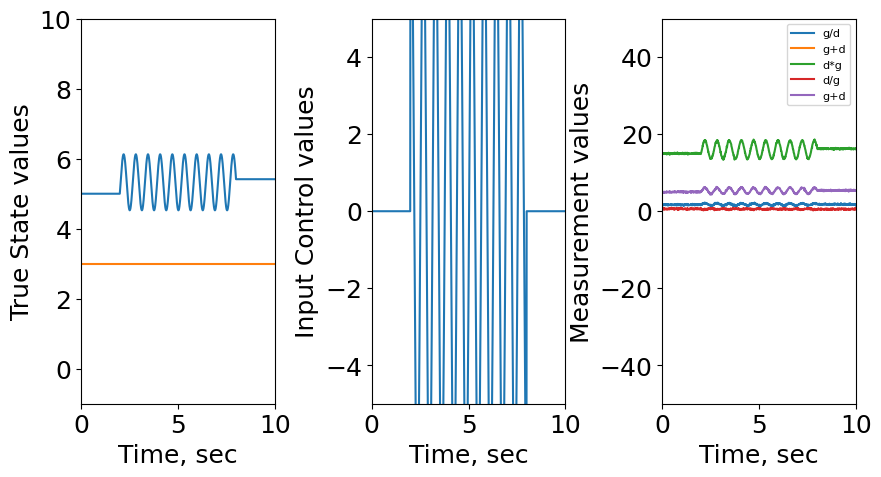

In [159]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('True State values')

ax.set_ylim([-1, 10])
ax.set_xlim([0, 10])

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Input Control values')

ax.set_ylim([-5, 5])
ax.set_xlim([0, 10])

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:], label='g/d')
ax.plot(tsim, Y[1,:], label='g+d')
ax.plot(tsim, Y[2,:], label='d*g')
ax.plot(tsim, Y[3,:], label='d/g')
ax.plot(tsim, Y[4,:], label='g+d')
#ax.plot(tsim, Y[1,:])

# legend on the right
ax.legend(loc='upper right', fontsize=8)

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')
ax.set_ylim([-50, 50])
ax.set_xlim([0, 10])

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays. 

## Initial conditions
Set up the initial conditions for the EKF. 

In [111]:
# Initial conditions
x0 = np.array([[5], [2.5]])
P0 = 1000000*np.eye(2)

# Noise defined by measurement noise
R = sys.std**2*np.eye(len(Y))
print(R.shape)

# Fairly accurate model
Q = 5e-4*np.eye(2)

(3, 3)


In [112]:
#!pip install git+https://github.com/florisvb/pyEKF.git

In [113]:
import ekf

In [ ]:
def f_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    g_dot = u # 0.01*g
    d_dot = 0
    x_new = np.atleast_2d(np.array([g + g_dot*dt, d + d_dot*dt])).T
    return x_new

def h_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    # define the sensors that I will be giving the EKF
    sensors = [np.array( [g/d] ), np.array(d**g), np.array(d*g), np.array(d/g), np.array(2*g + 2*d)]
    y = np.atleast_2d(np.hstack(sensors)).T
    return y

Use a modified R matrix to determine which combinations of sensors will be used by the EKF. Really large element of R means that the EKF will essentially ignore that sensor. According to Austin at least...

In [115]:
import itertools

def get_all_R(R_original):
    numbers = []
    for i in range(len(R)):
        numbers.append(i)

    all_combinations = []

    # Generate combinations
    for r in range(1, len(numbers) + 1):
        combs = list(itertools.combinations(numbers, r))
        all_combinations.extend(combs)

    R_modified = []

    for r in range(1, 5):
        for combo in itertools.combinations(range(3), r):
            matrix = R_original.copy()
            
            # Set large number for diagonals NOT in the combo
            for i in range(3):
                if i not in combo:
                    matrix[i, i] = 1e20
            
            R_modified.append(matrix)
    return R_modified

R_modified = get_all_R(R)

In [116]:
import pandas as pd

results = [pd.DataFrame(columns = ['x0_hat', 'x1_hat', 'P0', 'P1', 's0', 's1', 'invJk_x0', 'invJk_x1', '3sigma_x0', '3sigma_x1']) for _ in range(len(R_modified))]

for i in range(len(R_modified)):
    R = R_modified[i]
    # run the EKF

    xhat, P, s = ekf.ekf(Y, x0, f_d, h_d, Q, R, U)
    results[i]['x0_hat'] = xhat[0, :]
    results[i]['x1_hat'] = xhat[1, :]
    results[i]['P0'] = P[0, 0, :]
    results[i]['P1'] = P[1, 1, :]
    results[i]['s0'] = s[0, :]
    results[i]['s1'] = s[1, :]

In [117]:
# print(results[0])

## Plot Results
Plot the results of the EKF without considering the 3 sigma bounds. 

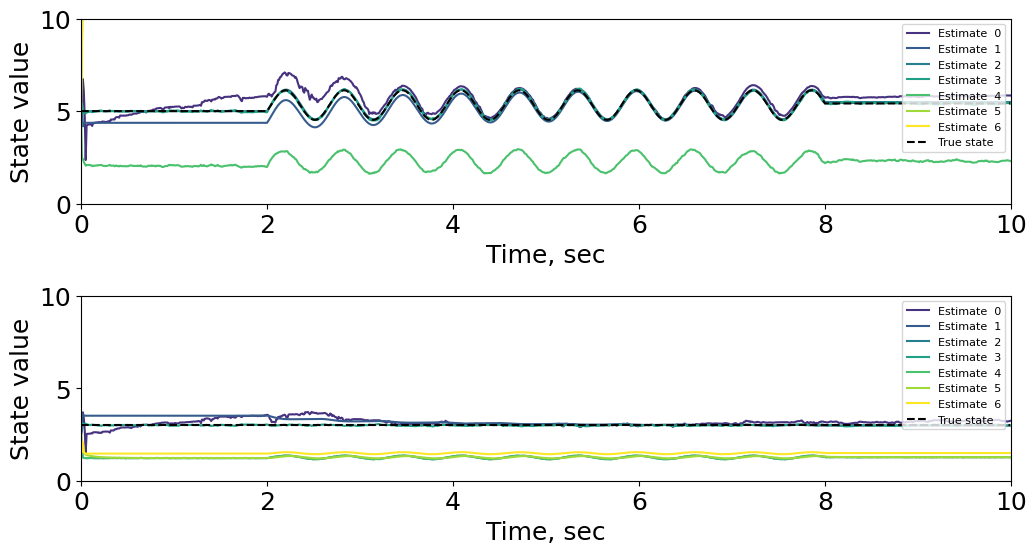

In [118]:
def kf_plot(num_plots, data, allR, time, states):
    fig, axs = plt.subplots(len(num_plots), 1, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('viridis', len(allR)+1)
    for j in range(len(num_plots)):
        for i in range(len(allR)):
            axs[j].plot(time, data[i][states[j]], label=f'Estimate  {i}', color=cmap(i+1))
        axs[j].set_xlabel('Time, sec')
        axs[j].set_ylabel('State value')
        axs[j].set_ylim([0, 10])
        axs[j].set_xlim([0, 10])
        axs[j].plot(time, X[j, :], label='True state', linestyle='--', color='black')
        axs[j].legend(loc='upper right', fontsize=8)
    plt.show()

kf_plot([0, 1], results, R_modified, tsim, ['x0_hat', 'x1_hat'])


# Cramer Rao Bound

### numerical jacobian

Maybe could be more efficient using ``jax``?

In [119]:
def jacobian(f, x0, u0, epsilon=0.001):
    
    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)
        
    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)
    
    return np.matrix(np.vstack(Aj)), np.matrix(np.vstack(Bj))

### cramer rao bound

In [120]:
inv = np.linalg.inv

def compute_invJk_diags(data, allR, time):
    for i in range(len(allR)):
        Jk = inv(P0)
        Ri = allR[i]

        for j in range(len(time)):
            xhat_j = np.array([data[i]['x0_hat'][j], data[i]['x1_hat'][j]])
            u_j = U[:,j]

            A, B = jacobian(f_d, np.ravel(xhat_j), np.ravel(u_j))
            C, D = jacobian(h_d, np.ravel(xhat_j), np.ravel(u_j))

            Jk = inv(Q) - inv(Q)@A@inv(Jk + A.T@inv(Q)@A)@A.T@inv(Q) + C.T@inv(Ri)@C

            lamb = 1e-5
            Jk = Jk + lamb*np.eye(np.shape(Jk)[0])
            invJk = inv(Jk)

            data[i].at[j, 'invJk_x0'] = np.diag(invJk)[0]
            data[i].at[j, 'invJk_x1'] = np.diag(invJk)[1]       

compute_invJk_diags(results, R_modified, tsim)

In [121]:
def compute_3sigma(data, allR, time):
    for i in range(len(allR)):
        for j in range(len(time)):
            three_sigma_x0 = 3 * np.sqrt(data[i]['invJk_x0'][j])
            three_sigma_x1 = 3 * np.sqrt(data[i]['invJk_x1'][j])
            data[i].at[j, '3sigma_x0'] = three_sigma_x0
            data[i].at[j, '3sigma_x1'] = three_sigma_x1

compute_3sigma(results, R_modified, tsim)


### show CRB

Red dashed lines are 3-sigma bounds determined by the KF.
Gray shading is the 3-sigma CRB bound. 

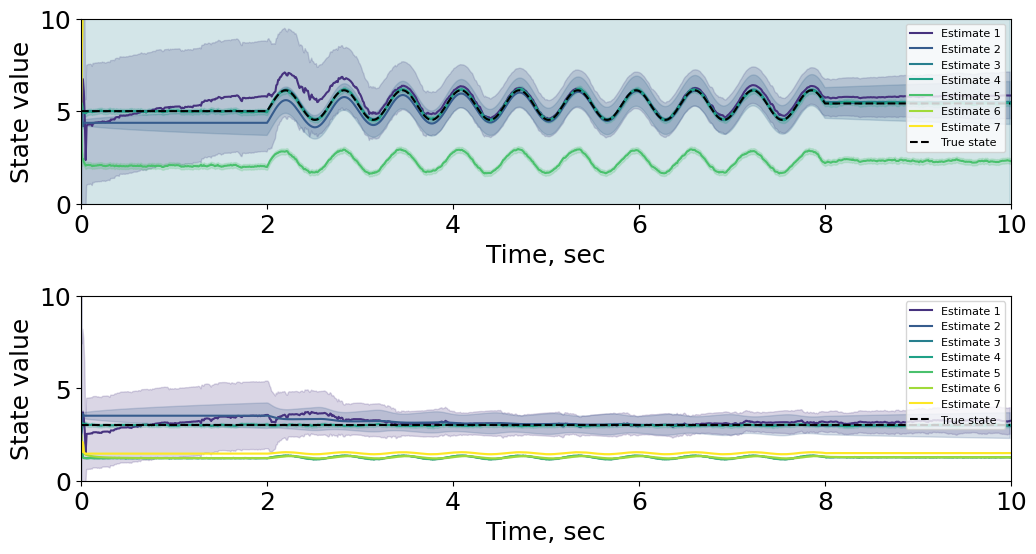

In [122]:
def threesigma_plot(num_plots, data, allR, time, states, sigmas):
    fig, axs = plt.subplots(len(num_plots), 1, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('viridis', len(allR)+1)
    for j in range(len(num_plots)):
        for i in range(len(allR)):
            state_array = np.asarray(data[i][states[j]], dtype=float)
            sigma_array = np.asarray(data[i][sigmas[j]], dtype=float)

            axs[j].plot(time, state_array, label=f'Estimate {i+1}', color=cmap(i+1))
            axs[j].fill_between(time, state_array - sigma_array, state_array + sigma_array, 
                                alpha=0.2, color=cmap(i+1))

        axs[j].set_xlabel('Time, sec')
        axs[j].set_ylabel('State value')
        axs[j].set_ylim([0, 10])
        axs[j].set_xlim([0, 10])
        axs[j].plot(time, X[j, :], label='True state', linestyle='--', color='black')
        axs[j].legend(loc='upper right', fontsize=8)
    plt.show()

threesigma_plot([0, 1], results, R_modified, tsim, ['x0_hat', 'x1_hat'], ['3sigma_x0', '3sigma_x1'])

# Sorting out based on error

In [123]:
# for every position and velocity, if invJk is bigger than 1, then we want to disregard the data
# we will use invJk to determine if the data is trustworthy or not
def find_trustworthy(data, allR, state_invJk):
    trustworthy=[]
    for i in range(len(allR)):
        if np.mean(data[i][state_invJk]) < 100:
            trustworthy.append(i)
    return trustworthy

trustworthy_x0 = find_trustworthy(results, R_modified, 'invJk_x0')
trustworthy_x1 = find_trustworthy(results, R_modified, 'invJk_x1')

print('valid combos x0: ', len(trustworthy_x0))
print(trustworthy_x0)
print('valid combos x1: ', len(trustworthy_x1))
print(trustworthy_x1)
    

valid combos x0:  6
[0, 1, 3, 4, 5, 6]
valid combos x1:  7
[0, 1, 2, 3, 4, 5, 6]


## Re-plot only the trustworthy measurements

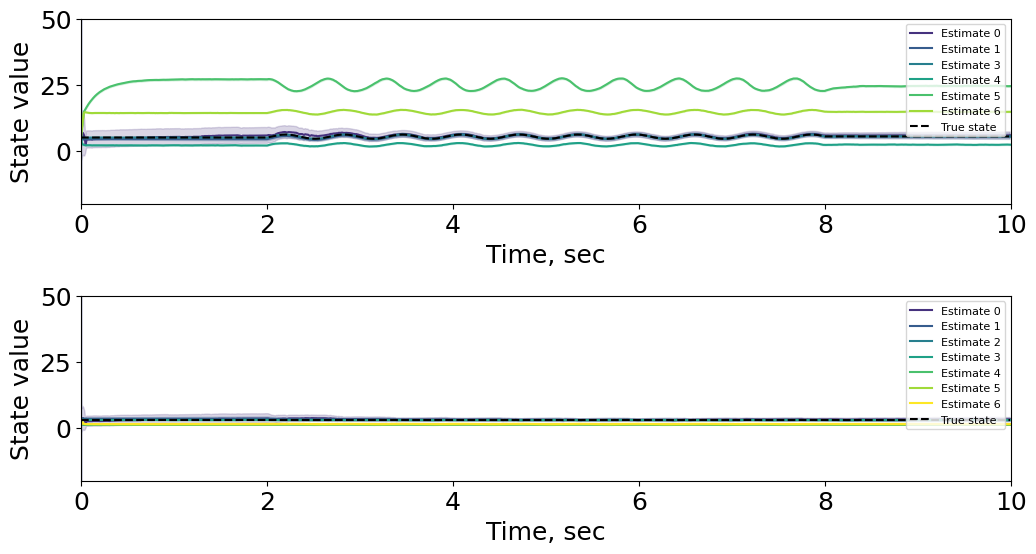

In [124]:
# # Same plot as before, just only for the trustworthy data
def trustworthy_plot(num_plots, data, allR, trustworthy_indices, time, states, sigmas):
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 6))
    if num_plots == 1:
        axs = [axs]
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('viridis', len(allR)+1)
    for i in range(num_plots):
        indices = trustworthy_indices[i]
        for j in range(len(indices)):
            state_array = np.asarray(data[indices[j]][states[i]], dtype=float)
            sigma_array = np.asarray(data[indices[j]][sigmas[i]], dtype=float)
            axs[i].plot(time, state_array, label=f'Estimate {indices[j]}', color=cmap(j+1))
            axs[i].fill_between(time, state_array - sigma_array, state_array + sigma_array,
                                alpha=0.2, color=cmap(j+1))
        axs[i].set_xlabel('Time, sec')
        axs[i].set_ylabel('State value')
        axs[i].set_ylim([-20, 50])
        axs[i].set_xlim([0, 10])
        axs[i].plot(time, X[i, :], label='True state', linestyle='--', color='black')
        axs[i].legend(loc='upper right', fontsize=8)
    plt.show()


trustworthy = [trustworthy_x0, trustworthy_x1]
trustworthy_plot(2, results, R_modified, trustworthy, tsim, ['x0_hat', 'x1_hat'], ['3sigma_x0', '3sigma_x1'])


# Most Observable Section

In [125]:
# compute the average of the 3 sigma bounds for the trustowrthy data of both states\     
def find_trustworthy_windows(data, state, sigma, trustworthy_indices, threshold):
    time = 10
    window_size = 1
    step = 0.01
    samples_per_window = int(window_size/step)
    start = None
    windows = []
    for i in range(int(time/window_size)):
        windows.append([i*window_size, (i+1)*window_size])
    trustworthy_windows = []

    for i in range(len(windows)):
        this_window = windows[i]
        window_3sigma_avg = []
        for j in range(len(trustworthy_indices)):
            window_3sigma_avg.append(np.mean(data[trustworthy_indices[j]][sigma][int(this_window[0]*100):int(this_window[1]*100)]))
        avg = np.mean(window_3sigma_avg)
        if avg < threshold:
            trustworthy_windows.append(windows[i])
        else:
            continue
    return trustworthy_windows

trustworthy_windows_x0 = find_trustworthy_windows(results, 'x0_hat', '3sigma_x0', trustworthy_x0, 0.45)
trustworthy_windows_x1 = find_trustworthy_windows(results, 'x1_hat', '3sigma_x1', trustworthy_x1, 0.3)
print(trustworthy_windows_x0)
print(trustworthy_windows_x1)


[[3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9]]
[[2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]


Now, plot only the data from the trustworthy windows.

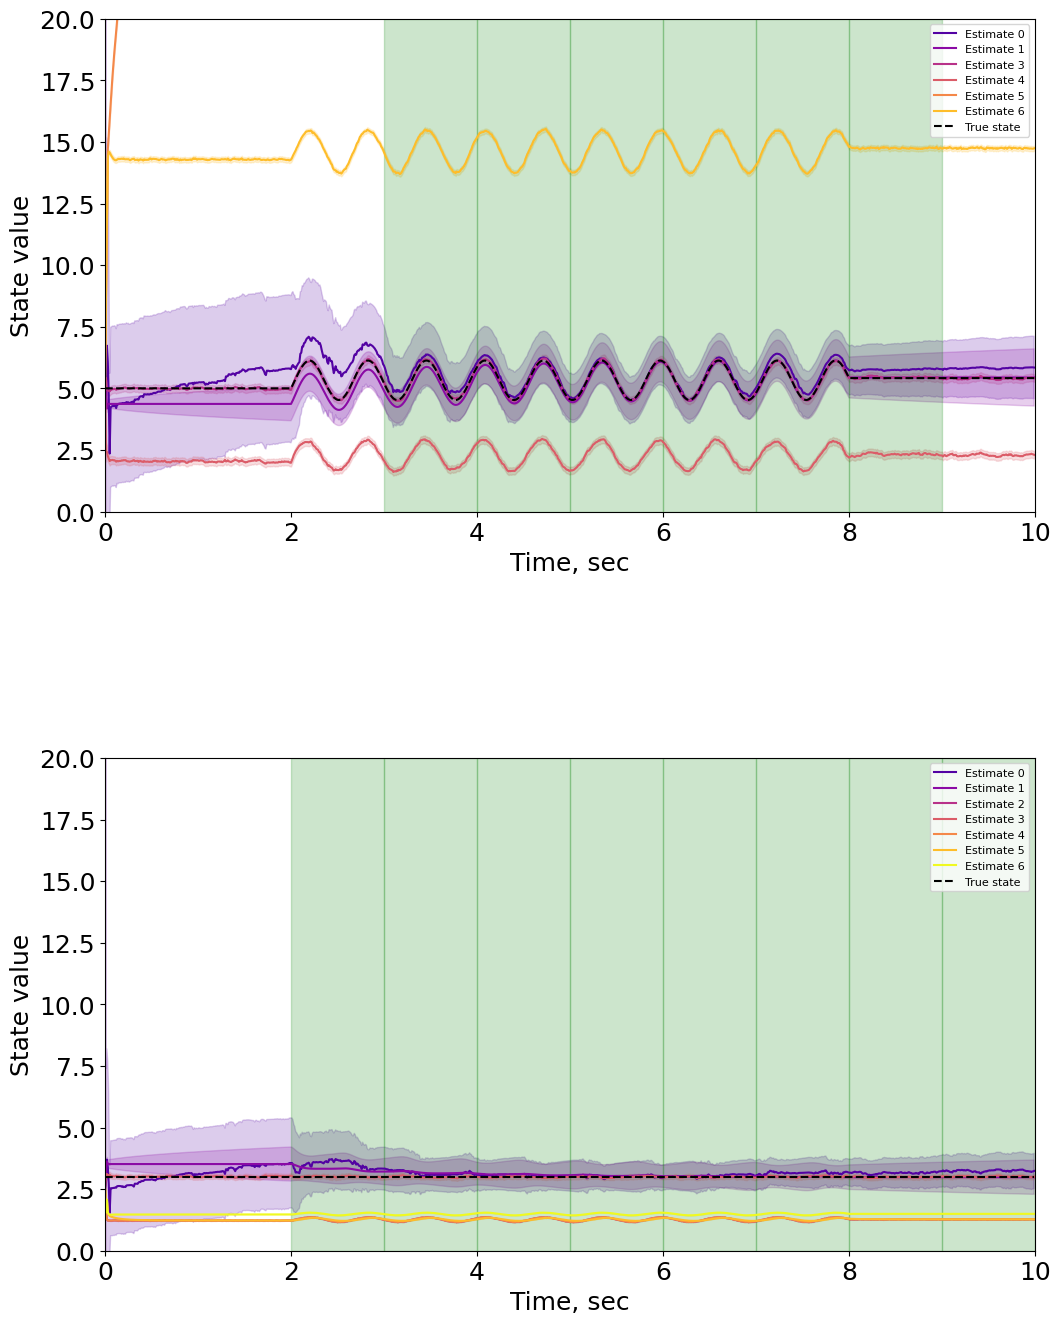

In [126]:
def trustworthy_plot(num_plots, data, allR, trustworthy_indices, time, states, sigmas, highlighted_windows):
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 16))
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('plasma', len(allR)+1)
    
    for i in range(num_plots):
        indices = trustworthy_indices[i]
        for j in range(len(indices)):
            state_array = np.asarray(data[indices[j]][states[i]], dtype=float)
            sigma_array = np.asarray(data[indices[j]][sigmas[i]], dtype=float)
            axs[i].plot(time, state_array, label=f'Estimate {indices[j]}', color=cmap(j+1))
            axs[i].fill_between(time, state_array - sigma_array, state_array + sigma_array,
                                alpha=0.2, color=cmap(j+1))
        axs[i].set_xlabel('Time, sec')
        axs[i].set_ylabel('State value')
        axs[i].set_ylim([0, 20])
        axs[i].set_xlim([0, 10])
        axs[i].plot(time, X[i, :], label='True state', linestyle='--', color='black')
        axs[i].legend(loc='upper right', fontsize=8)
    # highlight the trsutworthy windows with green
    for i in range(len(highlighted_windows)):
        for j in range(len(highlighted_windows[i])):
            axs[i].axvspan(highlighted_windows[i][j][0], highlighted_windows[i][j][1], color='green', alpha=0.2)
    plt.show()

trustworthy = [trustworthy_x0, trustworthy_x1]
windows = [trustworthy_windows_x0, trustworthy_windows_x1]
trustworthy_plot(2, results, R_modified, trustworthy, tsim, ['x0_hat', 'x1_hat'], ['3sigma_x0', '3sigma_x1'], windows)


# Agreement Heatmap
Now, put all the trustworthy measurements into a heatmap to how they agree. Here are the required functions:

In [127]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def get_time(trustworthy_windows):
    window_size = 1
    step = 0.01
    samples_per_window = int(window_size/step)
    time_indices = []
    for i in range(len(trustworthy_windows)):
        time_indices.append([int(trustworthy_windows[i][0]*samples_per_window), int(trustworthy_windows[i][1]* samples_per_window)])
    start = time_indices[0][0]
    end = time_indices[-1][1]
    return start, end

def make_adj_matrix(data, trustworthy_indices, state, time_start, time_end, three_sigma):
    adj_matrix = np.ones((len(trustworthy_indices), len(trustworthy_indices)))
    for i in range(len(trustworthy_indices)):
        for j in range(len(trustworthy_indices)):
            if i == j: continue
            else:
                data_i = np.array(data[trustworthy_indices[i]][state][time_start:time_end])
                data_j = np.array(data[trustworthy_indices[j]][state][time_start:time_end])
                sigma_i = np.array(data[trustworthy_indices[i]][three_sigma][time_start:time_end])
                overlap = []
                for k in range(len(data_i)):
                    thresh = sigma_i[k]* 1
                    if (data_i[k]-thresh < data_j[k] < data_i[k]+thresh):
                        overlap.append(1)
                    else:
                        overlap.append(0)
                overlap = np.array(overlap)
                adj_matrix[i, j] = np.mean(overlap)
    return adj_matrix

# function to plot the adjacency matrix
def plot_adjacency_matrix(matrix, indices, title):
    # sort the matrix based on the sum of rows
    sums = matrix.sum(axis=1)
    sorted_indices = np.argsort(sums)[::-1]
    matrix = matrix[sorted_indices, :][:, sorted_indices]

    indices = [indices[i] for i in sorted_indices]

    # Create a custom colormap
    colors =["red", "blue"]
    cmap = "custom colormap"
    custom_cmap = LinearSegmentedColormap.from_list(cmap, colors, N=100)

    # plot the adjacency matrix with the custom color map
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(matrix, cmap=custom_cmap, annot=True, fmt=".2f", cbar=False, square=True, linewidths=.5, annot_kws={"size": 5})
    ax.set_xticklabels(indices)
    ax.set_yticklabels(indices)
    ax.set_title(title)
    ax.set_xlabel("How much does the data of this sensor combo...")
    ax.set_ylabel("Fall into the error range of this sensor combo?")
    # font size
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()


Making the adjacency matrices and plotting them.

[0, 1, 3, 4, 5, 6]


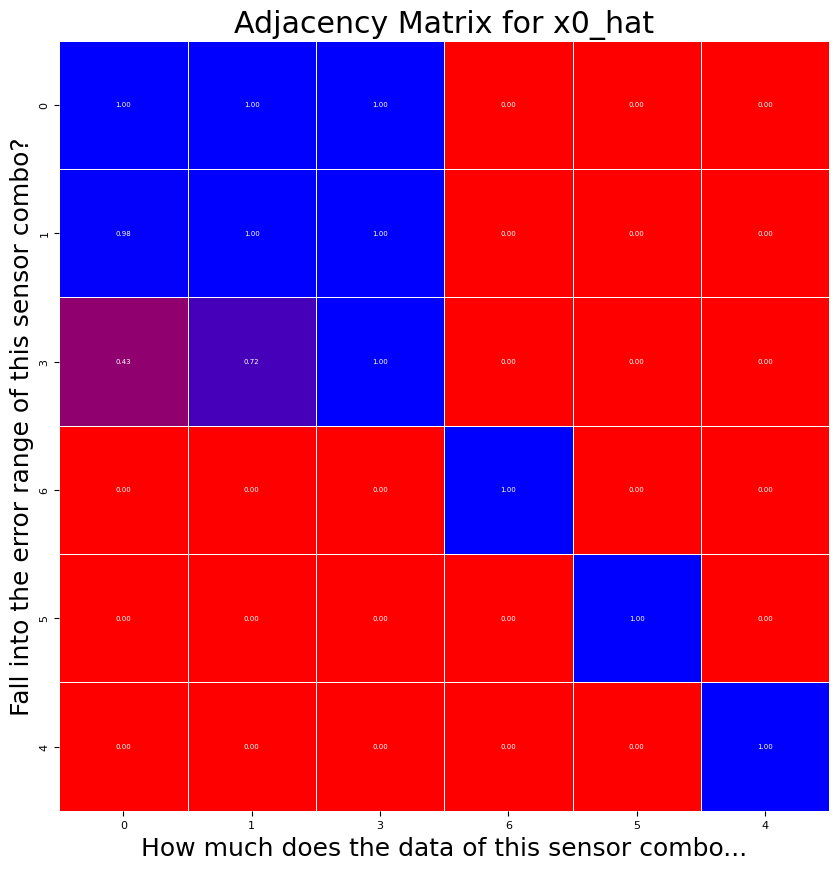

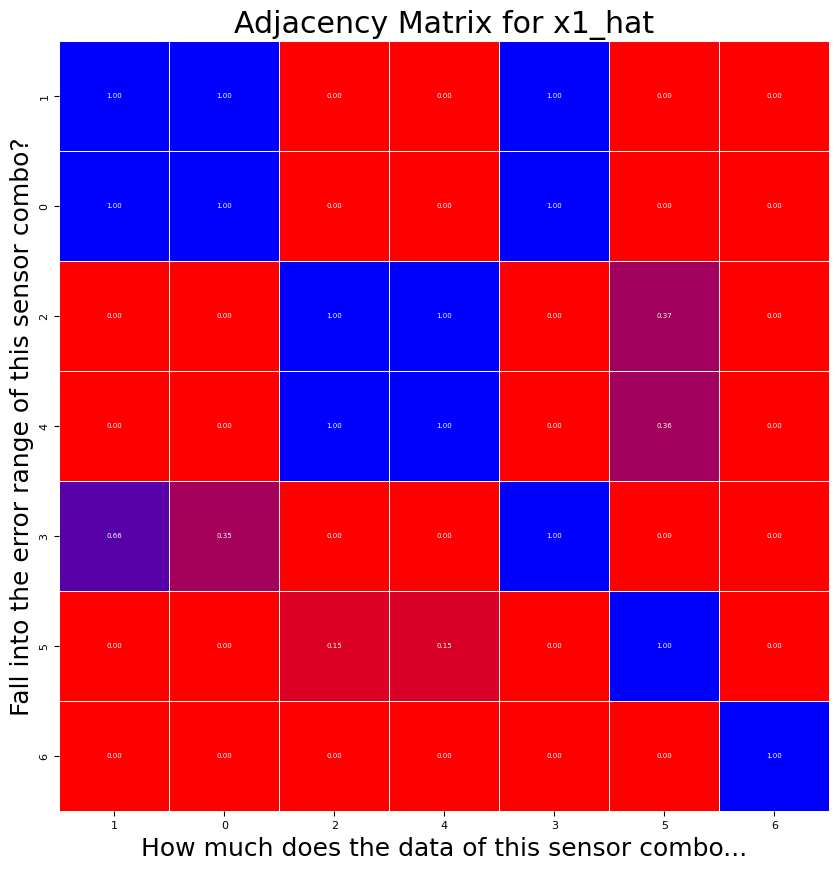

In [128]:
x0_start, x0_end = get_time(trustworthy_windows_x0)
x1_start, x1_end = get_time(trustworthy_windows_x1)


adj_x0 = make_adj_matrix(results, trustworthy_x0, 'x0_hat', x0_start, x0_end, '3sigma_x0')
adj_x1 = make_adj_matrix(results, trustworthy_x1, 'x1_hat', x1_start, x1_end, '3sigma_x1')

trustworthy = [trustworthy_x0, trustworthy_x1]

print(trustworthy_x0)

plot_adjacency_matrix(adj_x0, trustworthy_x0, "Adjacency Matrix for x0_hat")
plot_adjacency_matrix(adj_x1, trustworthy_x1, "Adjacency Matrix for x1_hat")


# Sensor Identification 
Now, find the largest cliques and the sensors that are not in them.

Note that this function currently does not work properly as of May 6th. I tried to change some things to be in a function to make it more convinient and it kind of broke it. Work in progress......

In [133]:
import networkx as nx
# write a function that can idebntify the clusters in the adjacency matrix
def clusters(matrix, indices, thresh):
    matrix = np.array(matrix)
    threshold = thresh

    # threshold matrix
    binary_matrix = (matrix > threshold).astype(int)

    # Graph
    G = nx.from_numpy_array(binary_matrix)

    # find cliques
    cliques = list(nx.find_cliques(G))

    for i in range(len(cliques)):
        this_clique = cliques[i]
        for j in range(len(this_clique)):
            this_clique[j] = indices[this_clique[j]]
    
    largest_clique = max(cliques, key=len)
    # print(largest_clique)

    return largest_clique

def identify(clique):
    # v stack all the corresponsding Rs for the clique
    R_compiled = np.array([])
    for i in range(len(clique)):
        Ri = np.array(R_modified[clique[i]])
        if i == 0:
            R_compiled = Ri
        else:
            R_compiled = np.vstack((R_compiled, Ri))
    # only keep the unique rows
    R_compiled = np.unique(R_compiled, axis=0)
    # from R_compiled, identify the column that does not include 1e-2
    num = R_compiled[1][1]
    # Compare each element with the number
    matches = (R_compiled == num)
    # Check if any match exists in each column
    has_number = np.any(matches, axis=0)
    # Return columns without the number
    broken = np.where(~has_number)[0]
    print("Broken sensors: ", broken)

largest_clique_x0 = clusters(adj_x0, trustworthy_x0, 0.8)
largest_clique_x1 = clusters(adj_x1, trustworthy_x1, 0.8)

print(largest_clique_x0)
print(largest_clique_x1)

identify(largest_clique_x0)


# print()
# for i in range(len(largest_clique_x0)):
#     print(R_modified[trustworthy_x0[largest_clique_x0[i]]])
#     print()
for i in range(len(R_modified)):
    print(f"R_{i}:\n", R_modified[i])
    print()


[0, 1, 3]
[0, 1, 3]
Broken sensors:  [2]
R_0:
 [[1.e-02 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 1.e+20]]

R_1:
 [[1.e+20 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00]
 [0.e+00 0.e+00 1.e+20]]

R_2:
 [[1.e+20 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 1.e-02]]

R_3:
 [[1.e-02 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00]
 [0.e+00 0.e+00 1.e+20]]

R_4:
 [[1.e-02 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 1.e-02]]

R_5:
 [[1.e+20 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00]
 [0.e+00 0.e+00 1.e-02]]

R_6:
 [[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]

